In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import cellregulondb as crdb

## Load

In [2]:
df = pd.read_csv("../../tests/test_data/ionocyte_regulons.csv", index_col=0)

In [3]:
ra = crdb.RegulonAtlas()

In [4]:
ra.load_from_df(df)

/Users/jp30/Documents/projects/cellregulondb/cellregulondb/regulonatlas.py:95: UserWarning: Column 'celltype' not found in `self.adata.obs`. Available columns: ['transcription_factor', 'regulation', 'tissue', 'cell_type', 'author_cell_type', 'rss', 'n_genes'], set `self.cell_type_col` to the correct column name.
  warnings.warn(


In [5]:
ra.cell_type_col = "cell_type"

## Filter

In [6]:
regulons = ra.find_regulons(transcription_factors=['FOXI1', 'RFX2', 'KLF5'])

In [7]:
ra_sub = ra.subset(regulons=regulons.index.tolist())

In [8]:
ra_sub

RegulonAtlas object with 30 regulons, 1 cell types and 425 target genes.

In [9]:
G1 = ra_sub.to_networkx(min_regulon=3, min_degree_targets=2, subset="regulation == '+'")
G2 = ra_sub.to_networkx(min_regulon=3, min_degree_targets=2, subset="regulation == '-'")
G = nx.compose(G1, G2)

In [10]:
print(G)

DiGraph with 13 nodes and 22 edges


## Plot

In [21]:
# customise edge colors and labels
edge_cols = []
edge_labs = {}
for edge in G.edges:
    if edge in G1.edges and edge in G2.edges:
        edge_cols.append('black')
        edge_labs[edge] = "(+/-)"
    elif edge in G1.edges:
        edge_cols.append('cornflowerblue')
        edge_labs[edge] = "(+)"
    elif edge in G1.edges:
        edge_cols.append('coral')
        edge_labs[edge] = "(-)"

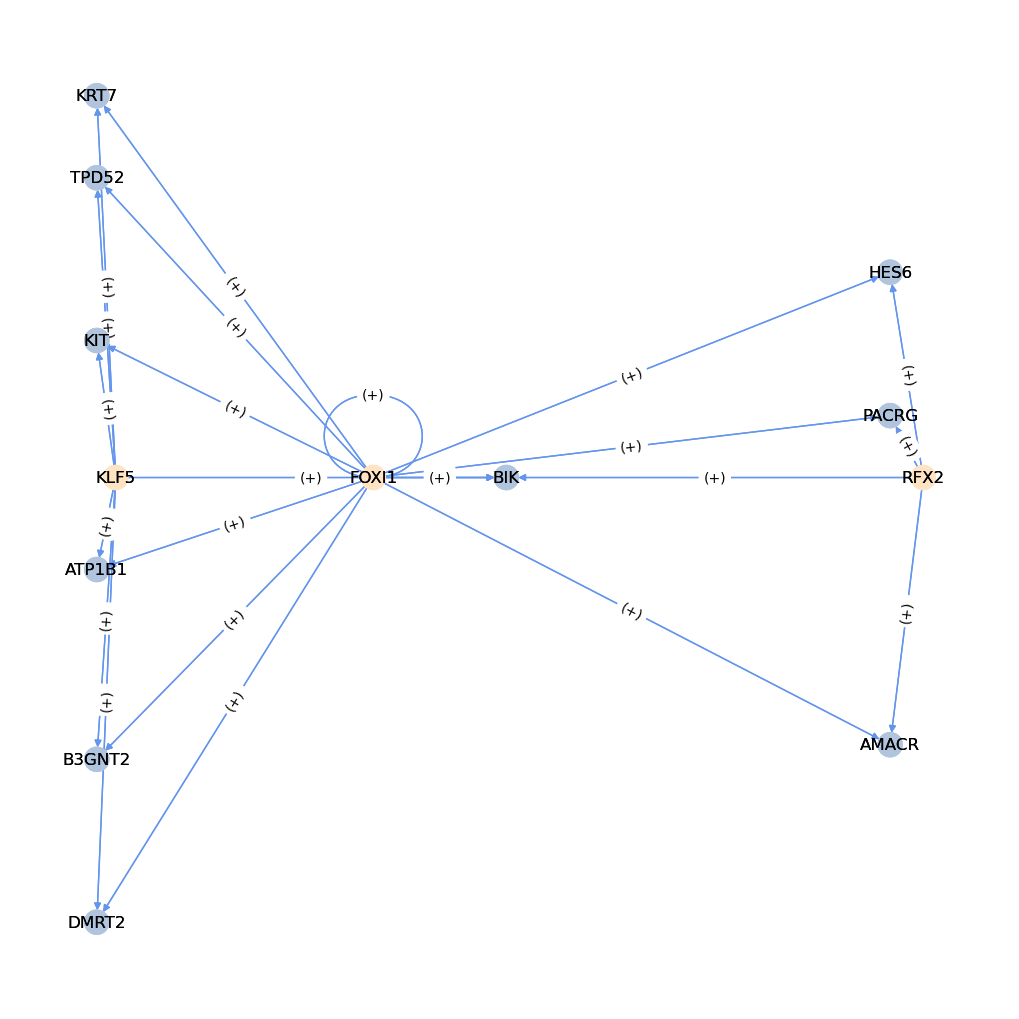

In [22]:
_ = crdb.util.plot_networkx(G, show=True, layout='spectral', edge_label_kwargs=dict(edge_labels=edge_labs), edge_color = edge_cols)